# Fire Stations - Assets accessibility

Questions we are trying to answer here, for a specific equipment type (class, sub-class) and a minimum condition level:
- Where are they located? (Fire Station)
- Where are the low accessibility areas fdr specific equipement?
- From anypoint, where is the closest in terms of driving distance?
- ...

In [1]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.network_analysis as na
import utils.data_processing as dp
import seaborn as sns
import folium

from pyproj import Proj, transform

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
%matplotlib inline

## Set bounding box

A bounding box of lattitude and longitude coordinates describes a rectangular geospatial region. For this report, I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection is important since only the entities *within* the bounding box are used in the analysis. The visual tool [here](http://boundingbox.klokantech.com/) is useful for obtaining the bounding box coordinates from a user-defined rectangle on the map. 

A key technical point is that [bounding box conventions do vary](https://wiki.openstreetmap.org/wiki/Bounding_Box
):
- The general definition uses (min Longitude , min Latitude , max Longitude , max Latitude), or  (W, S, E, N) 
- Pandana and Overpass use (S, W, N, E).

In [2]:
# Define bounding box (W, S, E, N) for the area we're interested in
# Copied from http://boundingbox.klokantech.com/
small = [172.4745,-41.8997,177.0893,-39.6219]

nz = [165.11,-47.73,179.17,-33.57]

general_bbox = small

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

## Create Query
The following section creates a query to get fire station data from Open Street Maps. The tags list can also be amended to get other amenities. The full list is [here](https://wiki.openstreetmap.org/wiki/Key:amenity).

The Overpass API query is not very easy to read but the main components are: 
- The bounding box: the area where we want the search performed. 
- Data Primitives: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. 
- Nodes: Single point with explicit [lat, lon] coordinates. Root primitive
- Ways: Collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 
- Relations: Represent the relationship of existing nodes and ways
- Tags: Metadata stored as key-value pairs. 

The main primitives used in this report are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for fuel station nodes. More information about the entities of Open Street Maps can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 

In [3]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ['fire_station']
objects = ['node', 'way'] # like way, node, relation

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox)

## Getting data from Openstreet Map
Getting data from Open Street Map is fairly simple via the Overpass API. All you need to do is construct the search query and reshape the result JSON into your data structure of choice. I've reshaped the data as a Pandas dataframe - basically a table with columns that contain metadata about each station. 

In [4]:
osmdf = dp.get_osm_data(compactOverpassQLstring, osm_bbox)

In [5]:
# Isolate a subset of useful attributes per fire station
sub_df = (osmdf[['id','type', 'lat', 'lon', 'amenity', 'name', 'operator']]
          .sort_values(['lat', 'lon'])
          .reset_index()
          .drop(columns='index'))


In [6]:
# Show all fire stations labelled as a node. i.e. with geolocation and with amenity
fire_stations = (sub_df.query('(amenity == "fire_station") & (type == "node")') 
              .dropna()
              .reset_index()
              .drop(columns='index'))
fire_stations

,id,type,lat,lon,amenity,name,operator
0,3289560400,node,-41.672538,174.076192,fire_station,Seddon Volunteer Fire Brigade,New Zealand Fire Service
1,3289577213,node,-41.561077,173.540548,fire_station,Wairau Valley Volunteer Fire Brigade,New Zealand Fire Service
2,1811986012,node,-41.506299,173.826349,fire_station,Renwick Volunteer Fire Brigade,New Zealand Fire Service
3,3289576318,node,-41.405237,173.041629,fire_station,Wakefield Volunteer Fire Brigade,New Zealand Fire Service
4,3289570174,node,-41.387962,172.822704,fire_station,Tapawera Volunteer Fire Brigade,New Zealand Fire Service
...,...,...,...,...,...,...,...
64,3287014470,node,-39.762664,174.632573,fire_station,Waverley Volunteer Fire Brigade,New Zealand Fire Service
65,2101198241,node,-39.757566,174.474982,fire_station,Patea Volunteer Fire Brigade,New Zealand Fire Service
66,2741819379,node,-39.677997,175.801111,fire_station,Taihape Volunteer Fire Brigade,New Zealand Fire Service
67,1263183848,node,-39.667009,176.879217,fire_station,Havelock North Volunteer Fire Brigade,New Zealand Fire Service


In [7]:
map_stations = folium.Map(location=[-41.29, 174.8],
                   zoom_start = 11)

for each in fire_stations.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']], popup=each[1]['name']).add_to(map_stations)

map_stations

 ## Get street network


In [ ]:
# get the network
H = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
#route, distance = na.get_shortest_path(origin_point, destination_point, H)
#plot_title = "Shortest distance between Z Kilbirnie and Z Vivian St is {} m".format(distance)
#fig, ax = ox.plot_graph_route(H, route)
#ax.set_title(plot_title)

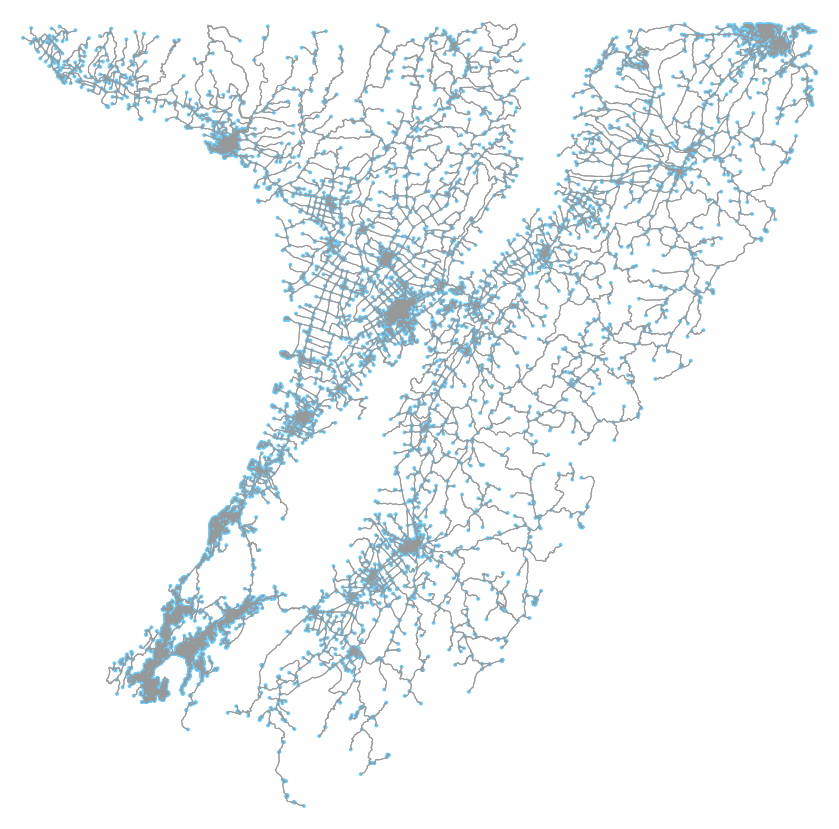

In [29]:
fig, ax = ox.plot_graph(H,fig_height=15)

# Accessibility analysis
The above analyses only consider the fuel stations and quantify implicit interactions (via road distance) between them. But we get the real benefit of spatial analyses when we consider interactions between the fuel stations and other entities - from humans to other businesses. One type of interaction with general entities is accessibility. Simple accessibility analyses convert the base geography of the region into a point grid, and compute distances between every point and the POIS. 
 

In [9]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fire station. n = 1 means the closest.
distance = 50000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 1

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(20, 20 * bbox_aspect_ratio)}
#plot_kwargs = {'s':5, 
#               'alpha':0.9, 
#               'cmap':'viridis_r', 
#               'edgecolor':'none'}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

In [10]:
# Generate accessibility network and save (removes the low connected nodes)
network = na.get_pandana_network(osm_bbox, impedance=distance)

## Accessibility to Fire Stations

In [11]:
stations_accessibility = na.get_accessibility(network, fire_stations, distance=distance, num_pois=num_pois)

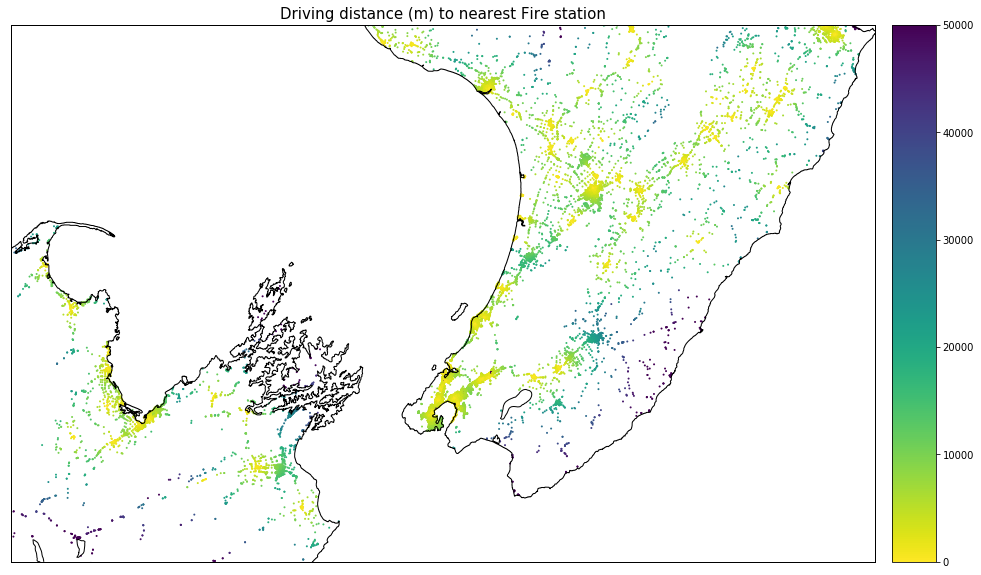

In [12]:
# Plot driving accessibility for fire stations
na.plot_accessibility(network, stations_accessibility[n], osm_bbox, 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

## Accessibility to assets

In [13]:
O_assets_df = pd.read_csv('../assets/O_assets_formated.csv')

In [14]:
# Adding the coodinates when available
map_station = pd.read_csv('../assets/map_station.csv').rename(columns={'FAMCU' : 'BUnit'})
def add_station_coord(df, map_station):
    return pd.merge(df, map_station, how='left').rename(columns={"Name": "station"})

O_assets_df = add_station_coord(O_assets_df, map_station)

In [15]:
# convert WGS84 to Web Mercator coords
merc_coord = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'),  list(O_assets_df.Lon), list(O_assets_df.Lat))
O_assets_df['x'] = merc_coord[0]
O_assets_df['y'] = merc_coord[1]

In [16]:
O_assets_df = O_assets_df[(O_assets_df.Lon>0) & (O_assets_df.Lat<0)]

In [17]:
x, y = O_assets_df.x, O_assets_df.y
O_assets_df["node_ids"] = network.get_node_ids(x, y)

In [ ]:
O_assets_df.head(100)

In [18]:
network.precompute(distance + 1)

In [19]:
# set pois for all types
for asset_type in list(O_assets_df.Type.unique()):
    if (asset_type != 'NO TYPE ASSIGNED!') & (len(O_assets_df[O_assets_df.Type == asset_type]) >0):
        pois_df = O_assets_df[O_assets_df.Type == asset_type]
        network.set_pois(category=asset_type,
                         x_col=pois_df['Lon'],
                         y_col=pois_df['Lat'],
                         maxdist=distance,
                         maxitems=num_pois)

In [19]:
network.save_hdf5(filename='./data/network_assets_-41.8997_172.4745_-39.6219_177.0893.h5', rm_nodes=None )

In [ ]:
# Plot driving accessibility

asset_type = 'BA-Cylinders-Composite' #Hoses-Delivery-Non Percolating'

accessibility = network.nearest_pois(distance=distance, category=asset_type, num_pois=num_pois)
na.plot_accessibility(network, accessibility[n], osm_bbox, amenity_type = asset_type,
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

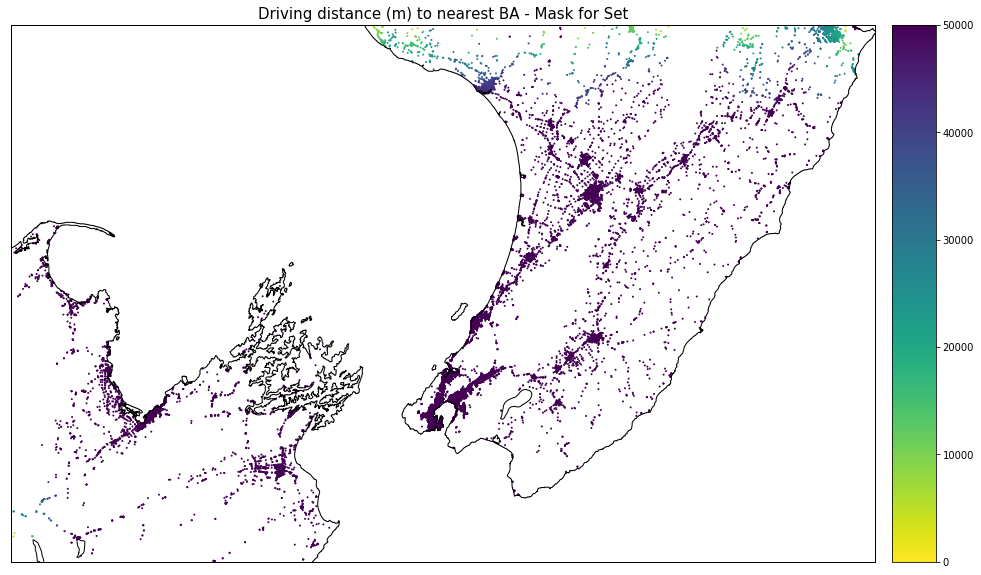

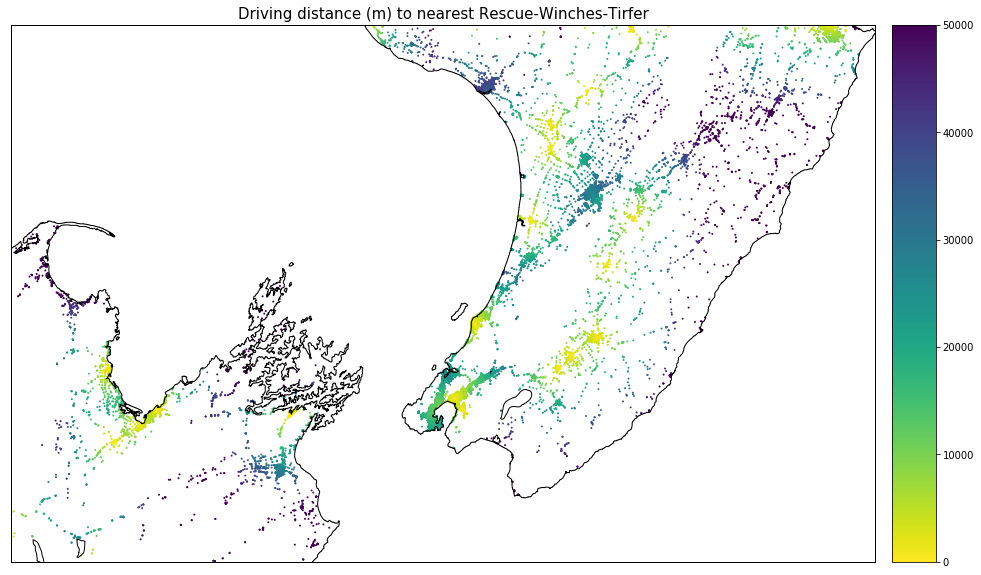

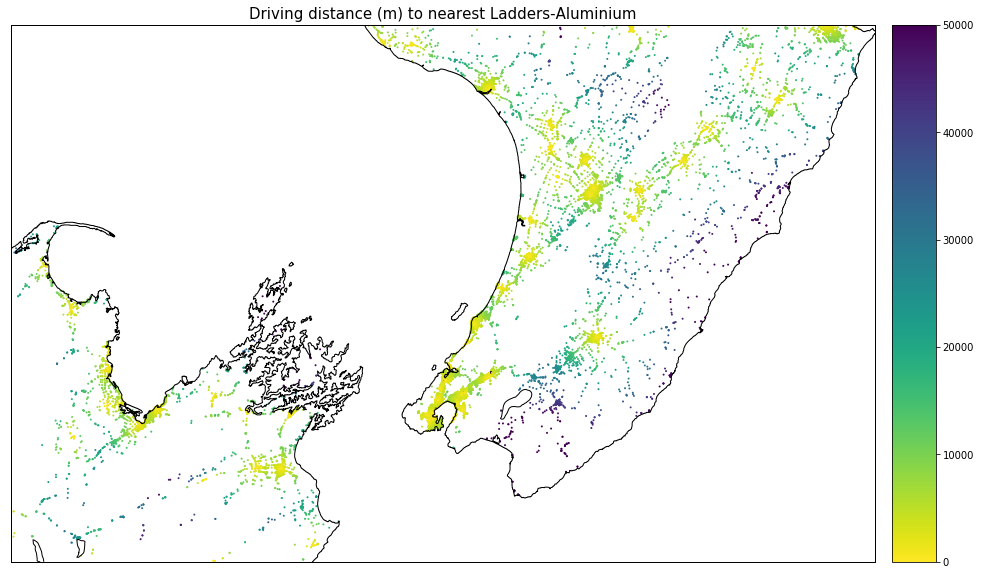

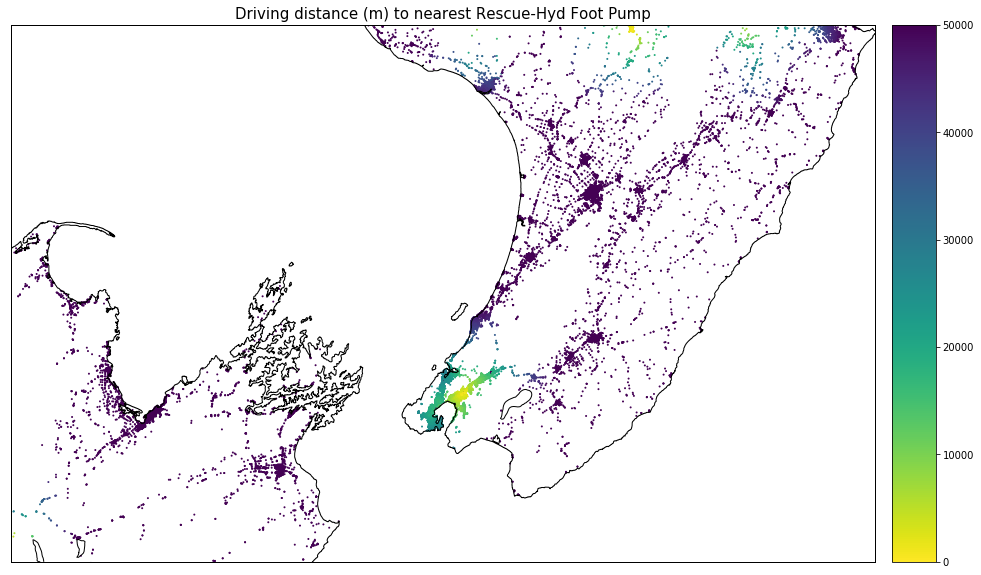

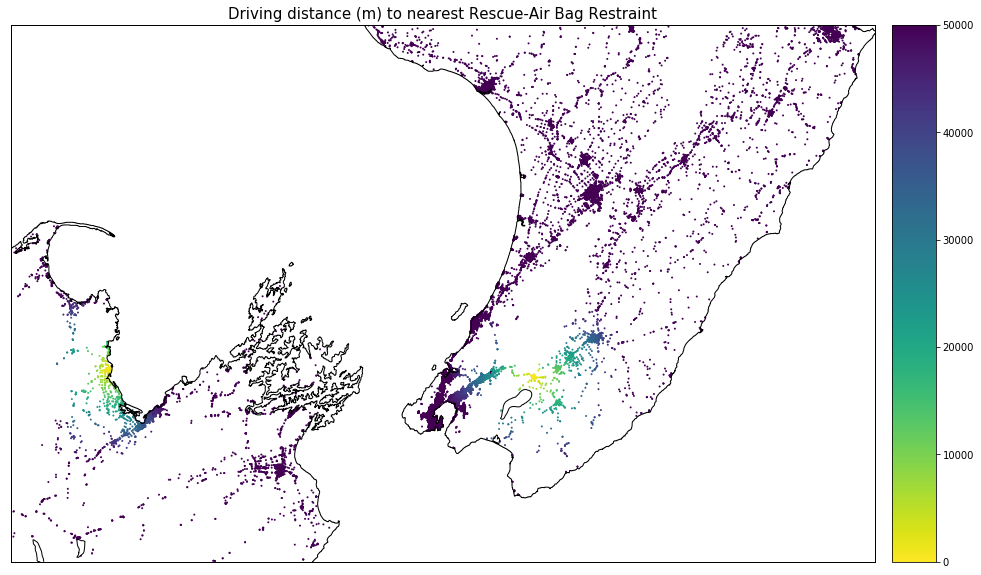

In [25]:
@interact_manual
def plot_accessibilty_asset(Asset_Type=list(O_assets_df.Type.unique()) ):
    accessibility = network.nearest_pois(distance=distance, category=Asset_Type, num_pois=num_pois)
    na.plot_accessibility(network, accessibility[n], osm_bbox, amenity_type = Asset_Type,
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)